<center>
    <b>Aplicacion con Red LSTM</b><br>
<br><br>
<b1>Pronóstico con indice S&P 500<b1>

<b1> Funciones y paquetes a utilizar  <b1>

In [1]:
# *******************************************************************
#      Comenzaremos cargando los paquetes que se necesitan
# *******************************************************************
import copy
import random
import sys 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import yfinance as yf 
%matplotlib inline
plt.style.use('ggplot') 
import seaborn as sns

               
def sliding_window(ts, features):
    X = []
    Y = []

    for i in range(features + 1, len(ts) + 1):
        X.append(ts[i - (features + 1):i - 1])
        Y.append([ts[i - 1]])

    return X, Y


def get_sp_timeseries():
    #inicio = '1992-4-11'
    #fin = '2021-4-11'
    #df = yf.download('^GSPC',start=inicio,end=fin)
    df = pd.read_csv('SP500_Datos.csv')
    ts = df['y'].astype(int).values.reshape(-1, 1)[-7000:]
    return ts

def get_training_datasets(ts, features, test_len):
    X, Y = sliding_window(ts, features)

    X_train, Y_train, X_test, Y_test = X[0:-test_len],\
                                       Y[0:-test_len],\
                                       X[-test_len:],\
                                       Y[-test_len:]

    train_len = round(len(ts) * 0.7)

    X_train, X_val, Y_train, Y_val = X_train[0:train_len],\
                                     X_train[train_len:],\
                                     Y_train[0:train_len],\
                                     Y_train[train_len:]

    x_train = torch.tensor(data = X_train).float()
    y_train = torch.tensor(data = Y_train).float()

    x_val = torch.tensor(data = X_val).float()
    y_val = torch.tensor(data = Y_val).float()

    x_test = torch.tensor(data = X_test).float()
    y_test = torch.tensor(data = Y_test).float()

    return x_train, x_val, x_test,\
           y_train.squeeze(1), y_val.squeeze(1), y_test.squeeze(1)

<b1> Modelo LSTM<b1>

In [2]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self,
                 hidden_size,
                 in_size = 1,
                 out_size = 1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size = in_size,
            hidden_size = hidden_size,
            batch_first = True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h = None):
        out, h = self.lstm(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, h

<b1>Se muestra la serie temporal para el S&P 500<b1>

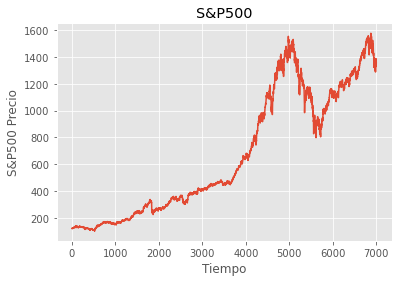

In [3]:
plt.title('S&P500')
plt.ylabel('S&P500 Precio')
plt.xlabel('Tiempo')
plt.plot(get_sp_timeseries())
plt.show()

<b1>Parámetros<b1>

In [4]:
# length of sliding window
features = 240
# length of test dataset
test_ts_len = 300
# size of LSTM hidden state
lstm_hidden_size = 24
# Optimizer learning rate
learning_rate = 0.03

training_epochs = 500

<b1>Preparación del conjunto de datos para el entrenamiento<b1>

In [5]:
ts = get_sp_timeseries()
scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(ts)
x_train, x_val, x_test, y_train, y_val, y_test =\
    get_training_datasets(scaled_ts, features, test_ts_len)

<ipython-input-1-b9d90335999b>:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(data = X_train).float()


Inicialización del Modelo LSTM

In [6]:
model = LSTM(hidden_size = lstm_hidden_size)
model.train()

LSTM(
  (lstm): LSTM(1, 24, batch_first=True)
  (fc): Linear(in_features=24, out_features=1, bias=True)
)

Entrenamiento

In [7]:

random.seed(1)
torch.manual_seed(1)

# Training
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
mse_loss = torch.nn.MSELoss()

best_model = None
min_val_loss = sys.maxsize

training_loss = []
validation_loss = []

for t in range(training_epochs):

    prediction, _ = model(x_train)
    loss = mse_loss(prediction, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    val_prediction, _ = model(x_val)
    val_loss = mse_loss(val_prediction, y_val)

    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(model)
        min_val_loss = val_loss.item()

    if t % 50 == 0:
        print(f'epoch {t} - '
              f'Loss: - {round(val_loss.item(), 6)}')

epoch 0 - Loss: - 0.285937
epoch 50 - Loss: - 0.000112
epoch 100 - Loss: - 6.4e-05
epoch 150 - Loss: - 7e-05
epoch 200 - Loss: - 6.7e-05
epoch 250 - Loss: - 6.3e-05
epoch 300 - Loss: - 6e-05
epoch 350 - Loss: - 5.8e-05
epoch 400 - Loss: - 5.6e-05
epoch 450 - Loss: - 5.4e-05


In [8]:
best_model.eval()
with torch.no_grad():
    _, h_list = best_model(x_val)
    # warm hidden and cell state
    h = tuple([(h[-1, -1, :]).unsqueeze(-2).unsqueeze(-2)
               for h in h_list])
    
    
    predicted = []
    for test_seq in x_test.tolist():
        x = torch.Tensor(data = [test_seq])
        # passing hidden state and cell through each iteration
        y, h = best_model(x, h)
        unscaled = scaler.inverse_transform(
            np.array(y.item()).reshape(-1, 1))[0][0]
        predicted.append(unscaled)

Se muestra el test del conjunto de datos

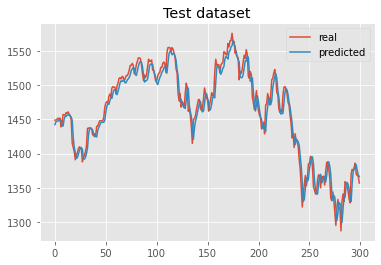

In [9]:
real = scaler.inverse_transform(y_test.tolist())
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()


<b1>Se muestra la funcion de perdida Loss<b1>

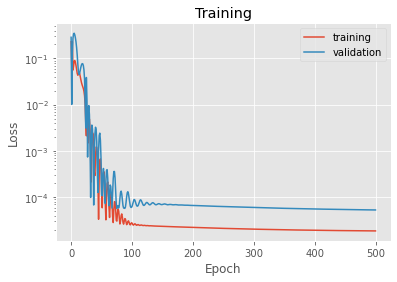

In [10]:
plt.title('Training')
plt.yscale('log')
plt.plot(training_loss, label = 'training')
plt.plot(validation_loss, label = 'validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Metricas 

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(predicted,real))
print("MAE: ", mean_absolute_error(predicted,real))
print("PPA: ", np.mean(real))

MSE:  187.1906305796628
MAE:  10.74158901810647
PPA:  1460.8766694575547
